# Qiskit Tutorial Part 2: Reversible Arithmetic

*This is part of the Qiskit Tutorial series by Yen Lee Loh.  Edited 2023-6-4.*

In this tutorial you'll learn how to do some basic arithmetic operations on a quantum computer, for what it's worth.

## 1. Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit
import qute


$\newcommand{\beq}{\qquad\begin{align}}$
$\newcommand{\eeq}{\end{align}}$
$\newcommand{\half}{\frac{1}{2}}$
$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\bra}[1]{\langle #1 \rvert}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$
$\newcommand{\mat}[1]{\underline{\underline{\mathbf{#1}}}}$


## 2. The CCX gate

The CCX gate is also known as a CCNOT gate or Toffoli gate.  The CCX gate flips the output qubit only if both input qubits are 1.  On a classical computer, this operation can be written in terms of Boolean operations in Python as `q2 ^= q0 & q1`:

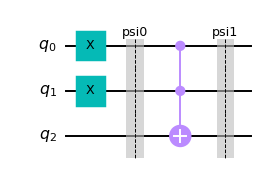

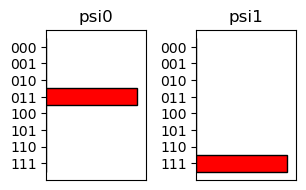

In [2]:
cir = qiskit.QuantumCircuit(3)
cir.x (0)         # try commenting out this line
cir.x (1)         # try commenting out this line
cir.save_statevector ('psi0')
cir.ccx(0,1,2)
cir.save_statevector ('psi1')
display(cir.draw('mpl', scale=.7))

res  = qute.run(cir)
psis = qute.getStatevectors(res, 'psi')
fig,axs = qute.axgrid (widths=[1,1], heights=[1.5], padl=.5)
ax=axs[0,0]; qute.plotStatevector(psis[0], horiz=True,ax=ax); ax.set_title('psi0')
ax=axs[0,1]; qute.plotStatevector(psis[1], horiz=True,ax=ax); ax.set_title('psi1');

The above example prepares the state $\ket{011}$ by applying X gates to qubits $q_0$ and $q_1$.  The CCX gate then flips qubit $q_2$.  Try removing one or both X gates and rerunning the code.  You will see that $q_2$ does not get flipped.

A neat trick is to use `x()` and `QFT()` to make a superposition of certain basis states with different phases.  This makes it easy to see the effect of an arithmetic circuit.  Run the code below:

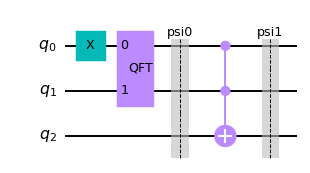

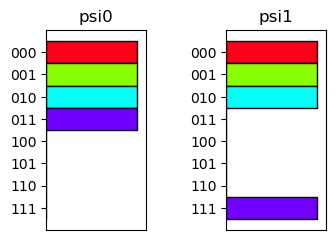

In [3]:
cir = qiskit.QuantumCircuit(3)
cir.x(0); cir.append (qiskit.circuit.library.QFT(2), [0,1])  # make interesting superposition
cir.save_statevector ('psi0')
cir.ccx(0,1,2)                                               # add CCX gate
cir.save_statevector ('psi1')
display(cir.draw('mpl', scale=.7))
res  = qute.run(cir)
psis = qute.getStatevectors(res, 'psi')
fig,axs = qute.axgrid (widths=[1,1], heights=[2], padl=.8)
ax=axs[0,0]; qute.plotStatevector(psis[0], horiz=True,ax=ax); ax.set_title('psi0')
ax=axs[0,1]; qute.plotStatevector(psis[1], horiz=True,ax=ax); ax.set_title('psi1');

The plots above clearly show that the CCX gate changes $\ket{011}$ into $\ket{111}$, but leaves other basis states unchanged.

## 3. The CCCX gate

The CCCX gate is also known as a C3X, CCCNOT, or C3NOT gate.  It implements the operation `q3 ^= q0 & q1 & q2`.  The target bit is flipped only if all three control bits are 1.  In Qiskit, we can add a CCCX gate using the `mcx()` function:

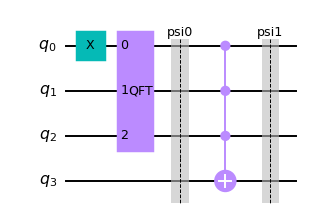

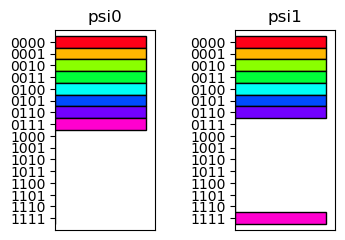

In [4]:
cir = qiskit.QuantumCircuit(4)
cir.x(0); cir.append (qiskit.circuit.library.QFT(3), [0,1,2])  # make interesting superposition
cir.save_statevector ('psi0')
cir.mcx([0,1,2], 3)                                            # add CCCX gate
cir.save_statevector ('psi1')
display(cir.draw('mpl', scale=.7))
res  = qute.run(cir)
psis = qute.getStatevectors(res, 'psi')
fig,axs = qute.axgrid (widths=[1,1], heights=[2], padl=.8)
ax=axs[0,0]; qute.plotStatevector(psis[0], horiz=True,ax=ax); ax.set_title('psi0')
ax=axs[0,1]; qute.plotStatevector(psis[1], horiz=True,ax=ax); ax.set_title('psi1');

The figure above shows that the CCCX gate maps $\ket{0111}$ to $\ket{1111}$ but leaves other states unchanged.

It is possible to achieve the effect of the CCCX gate using CCX gates, with the aid of an ancilla (bit 4):

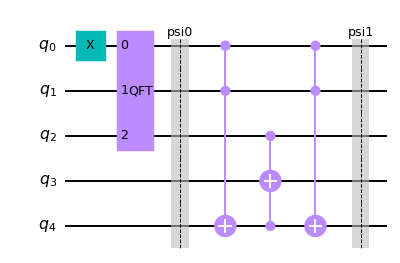

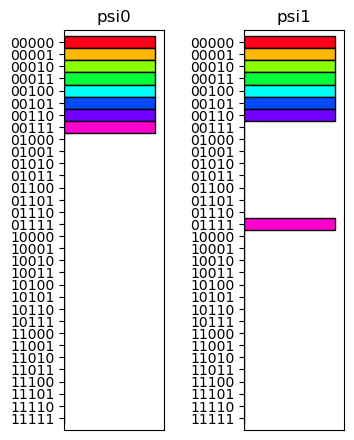

In [5]:
cir = qiskit.QuantumCircuit(5)
cir.x(0); cir.append (qiskit.circuit.library.QFT(3), [0,1,2])  # make interesting superposition
cir.save_statevector ('psi0')
cir.ccx(0,1,4)
cir.ccx(2,4,3)
cir.ccx(0,1,4)
cir.save_statevector ('psi1')
display(cir.draw('mpl', scale=.7))

res  = qute.run(cir)
psis = qute.getStatevectors(res, 'psi')
fig,axs = qute.axgrid (widths=[1,1], heights=[4], padl=.8)
ax=axs[0,0]; qute.plotStatevector(psis[0], horiz=True,ax=ax); ax.set_title('psi0')
ax=axs[0,1]; qute.plotStatevector(psis[1], horiz=True,ax=ax); ax.set_title('psi1');

## 3. Reversible 4-bit incrementer

Suppose you have a 4-bit integer whose bits are $(x_3,x_2,x_1,x_0)$, and you want to add 1 to this integer in-place.  This can be done using a ripple-carry incrementer.  This can be implemented as follows using Boolean operations in Python:

    c0 = 1
    c1 = x0      ;  x0 ^= c0
    c2 = c1 & x1 ;  x1 ^= c2
    c3 = c2 & x2 ;  x2 ^= c2 
    ;               x3 ^= c3

Directly translating this into reversible arithmetic would require ancillas to store the carry bits c0, c1, c2, and c3.  However, the above operations can be rearranged into the form of a carry-look-ahead incrementer.  Furthermore, instead of storing the carries in intermediate variables, one may simply write

    x3 ^= x0 & x1 & x2
    x2 ^= x0 & x1
    x1 ^= x0 
    x0 ^= 1

Thus, a 4-bit register can be incremented using CCCX, CCX, CX, and X gates:

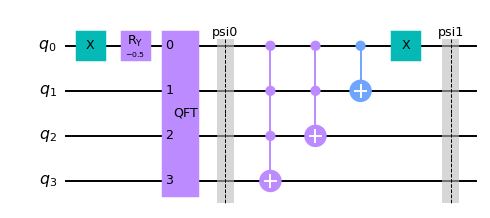

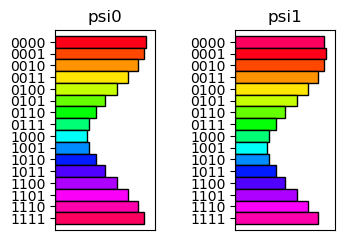

In [6]:
cir = qiskit.QuantumCircuit(4)
cir.x(0); cir.ry(-.5,0); cir.append (qiskit.circuit.library.QFT(4), [0,1,2,3])  # make interesting superposition
cir.save_statevector ('psi0')
cir.mcx ([0,1,2], 3)
cir.ccx (0,1,2)
cir.cx  (0,1)
cir.x   (0)
cir.save_statevector ('psi1')
display(cir.draw('mpl', scale=.7))
res  = qute.run(cir)
psis = qute.getStatevectors(res, 'psi')
fig,axs = qute.axgrid (widths=[1,1], heights=[2], padl=.8)
ax=axs[0,0]; qute.plotStatevector(psis[0], horiz=True,ax=ax); ax.set_title('psi0')
ax=axs[0,1]; qute.plotStatevector(psis[1], horiz=True,ax=ax); ax.set_title('psi1');

Each colored bar moves down one step.  The increment subcircuit maps 
$\ket{0000} \rightarrow \ket{0001}$, $\ket{0001} \rightarrow \ket{0010}$, $\dots$, $\ket{1111} \rightarrow \ket{0000}$, which corresponds to the operation $x := (x+1) \text{~mod~} 16$ as required.  The increment operation operates on all 16 basis states simultaneously.  We might say that the quantum computer is doing calculations in parallel.

## 2-bit multiplier

The circuit below multiplies a 2-bit integer by another 2-bit integer to give a 4-bit integer:

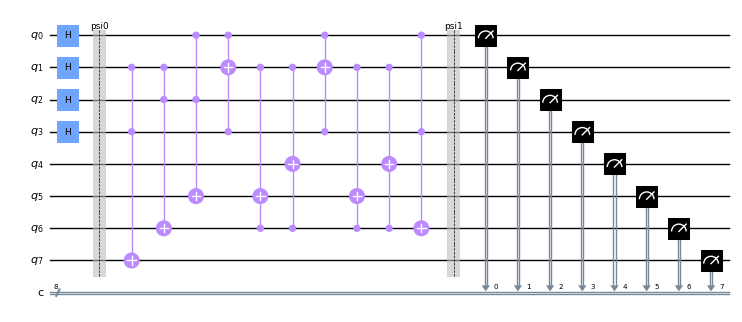

In [9]:
cir = qiskit.QuantumCircuit(8,8)
#======== Generate uniform superposition
cir.h([0,1,2,3])
cir.save_statevector ('psi0')
#======== Multiply input registers [0,1] and [2,3] to give output register [4,5,6,7] using ancilla-free circuit
cir.ccx(1,3,7)
cir.ccx(1,2,6)
cir.ccx(0,2,5)
cir.ccx(0,3,1)
cir.ccx(1,6,5)
cir.ccx(1,6,4)
cir.ccx(0,3,1)
cir.ccx(1,6,5)
cir.ccx(1,6,4)
cir.ccx(0,3,6)
cir.save_statevector ('psi1')
#======== Measure everything
cir.measure([0,1,2,3,4,5,6,7],[0,1,2,3,4,5,6,7])   # Measure q0,q1,q2,q3 and store in c0,c1,c2,c3
cir.draw('mpl', scale=.5)

In [10]:
# res  = qute.run(cir)
# psis = qute.getStatevectors(res, 'psi')
# fig,axs = qute.axgrid (widths=[1,1], heights=[2], padl=.8)
# ax=axs[0,0]; qute.plotStatevector(psis[0], horiz=True,ax=ax,tickInterval=16); ax.set_title('psi0')
# ax=axs[0,1]; qute.plotStatevector(psis[1], horiz=True,ax=ax,tickInterval=16); ax.set_title('psi1');

In [11]:
res = qute.run (cir, shots=1000)
cts = qute.getCounts(res)
print('Output = ', cts)
print ()
print ('   x    y      z')
ss = np.sort([s[::-1] for s in list(cts)])   # reverse order of bits in outputs
for s in ss:
  print (f'  {s[0:2]} * {s[2:4]} = {s[4:8]}')

Output =  {'00000010': 53, '01001001': 67, '00000001': 64, '10001010': 68, '00000100': 57, '11001011': 74, '00000011': 60, '11001110': 59, '00001000': 58, '00001100': 71, '00100101': 62, '01101101': 73, '01000110': 68, '10011111': 64, '01100111': 50, '00000000': 52}

   x    y      z
  00 * 00 = 0000
  00 * 01 = 0000
  00 * 10 = 0000
  00 * 11 = 0000
  01 * 00 = 0000
  01 * 01 = 0001
  01 * 10 = 0010
  01 * 11 = 0011
  10 * 00 = 0000
  10 * 01 = 0010
  10 * 10 = 0100
  10 * 11 = 0110
  11 * 00 = 0000
  11 * 01 = 0011
  11 * 10 = 0110
  11 * 11 = 1001


The quantum computer performs 16 multiplication operations in parallel.  However, each measurement only yields the result of one of those operations.  Thus, this is not a good way to use a quantum computer.

## Exercises

1. Build a half adder that takes two input qubits (q0 and q1) and calculates two output qubits `q2 = q0^q1` and `q3 = q0&q1` using CX and CCX gates.  Verify that your circuit works correctly for all four combinations of the input values.

2. Build a full adder that takes three input qubits (q0, q1, q2) and calculates two output qubits `q3 = q0^q1^q2` and `q4 = (q0&q1) ^ (q0&q2) ^ (q1&q2).`  Verify your circuit for all 8 input possibilities.

Suppose we want to add bit x and bit y to obtain a two-bit binary number, consisting of a carry bit $c$ and a sum bit $s$ such that $2c + s = x + y$.  In Boolean algebra, we want

$\qquad$$\begin{align}
c &= x y \\
s &= x \oplus y .
\end{align}$

We may compute the sum in-place and the carry out-of-place as follows:

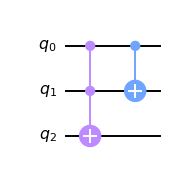

In [42]:
cir = qiskit.QuantumCircuit(3)
cir.ccx (0,1,2)
cir.cx  (0,1)
cir.draw('mpl',scale=.7)

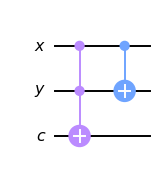

In [39]:
x = qiskit.QuantumRegister(1, 'x')
y = qiskit.QuantumRegister(1, 'y')
c = qiskit.QuantumRegister(1, 'c')
cir = qiskit.QuantumCircuit(x,y,c)
cir.ccx (x,y,c)
cir.cx  (x,y)
cir.draw('mpl',scale=.7)

# TBD: fix the belo

In [32]:
from collections import OrderedDict
from collections.abc import Iterable
import itertools

def bstrFromList (bitlist):
  try:    return ''.join([str(c) for c in bitlist[::-1]])
  except: return bitlist
def bstrFromInteger (thing, numBits=-1):
  if numBits==-1:
    return bin(thing)[2:]
  else:
    return bin(thing)[2:].zfill(numBits)
def bstr (thing, numBits=-1):
  if isinstance (thing, Iterable):
    return bstrFromList(thing)
  else:
    return bstrFromInteger(thing, numBits)
def dstrFromString (thing):
  if isinstance(thing,str):
    numDigits = len(thing)
    fmt = '{:' + str(numDigits) + 'd}'
    return fmt.format (int(thing,2))
def dstr (thing):
  return dstrFromString (thing)

def initRegister (cir, register, value):
  '''
  Add instructions to circuit <cir> to XOR register <register> with an integer <value>
  '''
  for i in range(register.size):
    if (value>>i)&1:
      cir.x(register[i])
def test (cir, inputs, values, outputs, formatter=lambda x:x):
  '''
  Suppose we have a circuit that computes x := (x+y) mod b using zero ancillas z and borrowed ancillas b. 
  We can test it using

      test (cir, [x,y,m,z,b], [range(16), 'a', 5, 0, 'r'], [x,z,b])

  With these arguments:

      m = 5                  the m register is initialized to a fixed value
      x = [0,1,2,...,15]     the program loops over several values of x
      'a'                    the program loops over all possible values of y
      z = 0                  the zero ancillas are initialized to zero
      b = random             the borrowed ancillas are initialized randomly

  The program should generate output like this:

              Input          Output 

         x    y    m z b     x z b
      ------------------  --------
      0000 0000 0101 0 1  0000 0 1

  There should be an option for decimal or hexadecimal output.
  TBD: Need to designate inputs for PRINTING ONLY.....  dont want to be cluttered by stuff...
  the maini issue is that we need to parse the measured register bitstrings, which is a pain,
  as we would need to know which bits to extract
  '''
  #======== Convert each element of "values" to a list
  for i in range(len(values)):
    if values[i]=='a':
      values[i] = list(range(2**len(inputs[i])))
    elif not isinstance (values[i], Iterable):
      values[i] = [values[i]]
  #print (values)
  #======== Try looping over all combinations of input values  
  for comboTuple in itertools.product (*values):   # this is crucial!
    combo = list(comboTuple)
    for i in range(len(combo)):
      if combo[i]=='r':
        combo[i] = rng.integers(2**len(inputs[i]))
    #print (combo)
    
  #======== Prepare registers for output
  qRegs = list(OrderedDict.fromkeys(inputs+outputs))    # remove duplicates
  cRegs = [qiskit.ClassicalRegister(qReg.size,name=qReg.name+'_') for qReg in outputs] #output regs only!
  #sRegs = [qReg.name for qReg in qRegs]   # register names
  #======== Print input headings
  for qReg in inputs:
    fmt = '{' + f':>{len(qReg)}s' + '}'
    print (fmt.format(qReg.name), end=' ')  
  print ('| ', end='')
  #======== Print output headings
  for qReg in outputs:
    fmt = '{' + f':>{len(qReg)}s' + '}'
    print (fmt.format(qReg.name), end=' ')
  print ()
  #======== Loop over all combinations of input values for real
  for comboTuple in itertools.product (*values):
    combo = list(comboTuple)
    #======== Substitute 'r' by random integer
    for i in range(len(combo)):
      if combo[i]=='r':
        combo[i] = rng.integers(2**len(inputs[i]))
    #======== Build circuit
    cirI = qiskit.QuantumCircuit(*qRegs,*cRegs)    # initialization circuit
    cirM = qiskit.QuantumCircuit(*qRegs,*cRegs)    # measurement circuit
    for i in range(len(combo)):
      initRegister (cirI, inputs[i], combo[i])
    for outReg,cReg in zip(outputs,cRegs):
      cirM.measure(outReg,cReg)
    cirC = cirI.copy(); cirC.compose (cir, inplace=True); cirC.compose (cirM, inplace=True)
    #======== Build circuit
    sim = qiskit.Aer.get_backend('aer_simulator'); exe = qiskit.transpile(cirC, sim)
    job = sim.run(exe, shots=1); res = job.result(); cts = res.get_counts(exe)
    out = list(cts.keys())[0].split() [::-1]
    #======== Print inputs
    for i in range(len(combo)):
      val = bstr(combo[i], len(inputs[i]))
      print (formatter(val), end=' ')
    print ('| ', end='')
    #======== Print outputs
    for val in out:
      print (formatter(val),end=' ')
    print ()

In [35]:
test (cir, inputs=[x,y], values=[[0,1],[0,1]], outputs=[y,c])

x y | y c 
0 0 | 0 0 
0 1 | 1 0 
1 0 | 1 0 
1 1 | 0 1 
